In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import re

In [43]:
train_file = 'train_1.csv'
key_file = 'key_2.csv'

input_df = pd.read_csv('./data/' + train_file)
# input_df_dates = input_df.columns[1:]
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## Using regular expression to separate for different languages

In [4]:
def lang(Page):
    val = re.search('[a-z][a-z].wikipedia.org',Page)
    if val:
        return val[0][0:2]               
    return 'no_lang'

input_df['language'] = input_df.Page.map(lang)

language_set = {}
language_set['en'] = input_df[input_df.language=='en'].iloc[:,0:-1]
language_set['ja'] = input_df[input_df.language == 'ja'].iloc[:, 0:-1]
language_set['de'] = input_df[input_df.language == 'de'].iloc[:, 0:-1]
language_set['fr'] = input_df[input_df.language == 'fr'].iloc[:, 0:-1]
language_set['ru'] = input_df[input_df.language == 'ru'].iloc[:, 0:-1]
language_set['es'] = input_df[input_df.language == 'es'].iloc[:, 0:-1]
language_set['no_lang'] = input_df[input_df.language == 'no_lang'].iloc[:, 0:-1]

Summing up all the views for a day and for particular language 

In [5]:
total_view = {} 
for key in language_set:
    total_view[key] = language_set[key].iloc[:, 1:].sum(axis=0) / language_set[key].shape[0]

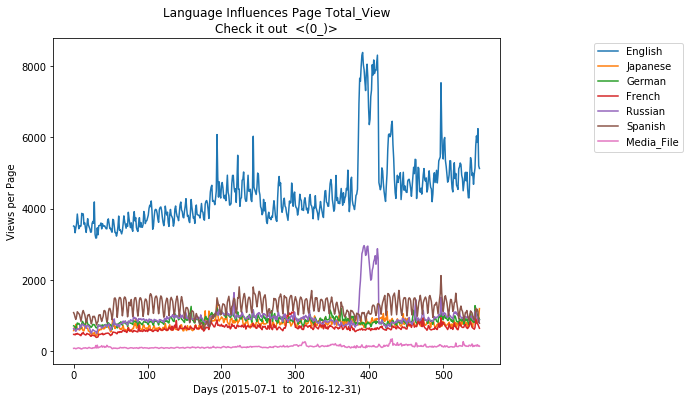

In [8]:
days = [r for r in range(total_view['en'].shape[0])]

plt.figure(figsize=(8, 6))
labels={'ja':'Japanese','de':'German','en' : 'English','no_lang':'Media_File','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'}

for key in total_view:
    plt.plot(days,total_view[key],label = labels[key])
    

plt.ylabel('Views per Page')
plt.xlabel('Days (2015-07-1  to  2016-12-31)')
plt.title('Language Influences Page Total_View\nCheck it out  <(0_)>')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.2, 1))
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

For using ARIMA model we need to make the data stationary so for that we need to check using rolling mean and standard deviation. Here we are working only for 'English' language and can be done for all languages similarly.

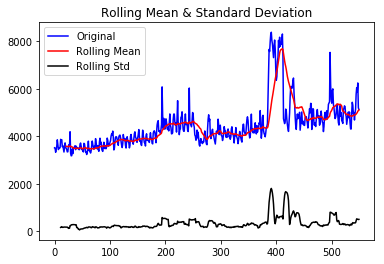

ADF Stastistic: -2.247284
p-value: 0.189534
The graph is non stationery
Critical values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [20]:
def test_stationarity(x):
    rolmean = x.rolling(window=22,center=False).mean()
    rolstd = x.rolling(window=12,center=False).std()
    
    orig = plt.plot(x.values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
test_stationarity(total_view['en'])

Now we will separate data under 3 categories: trends, seasonality and irregularity.

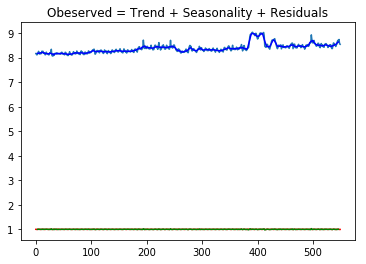

In [21]:
ts_log = np.log(total_view['en'])

decomposition = seasonal_decompose(ts_log.values, model='multiplicative',freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.title('Obeserved = Trend + Seasonality + Residuals')
plt.plot(ts_log.values,label='Observed')

plt.plot(trend, label='Trend',color='blue')
plt.plot(seasonal,label='Seasonality', color='red')
plt.plot(residual, label='Residuals', color='green')
plt.show()

Now we substract the dc shift from he trend which will make data stationary.

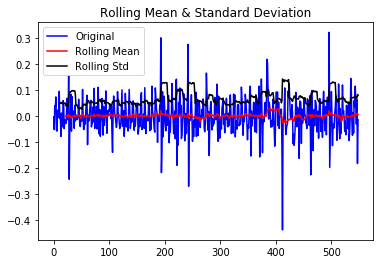

ADF Stastistic: -8.154260
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [22]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## Using ARIMA Model

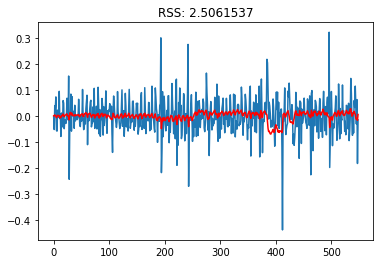

In [24]:
model = ARIMA(ts_log.values, order=(1,1,1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff.values)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff.values)**2))
plt.show()

Predicting traffic values for English language and comparing it with the orignal values

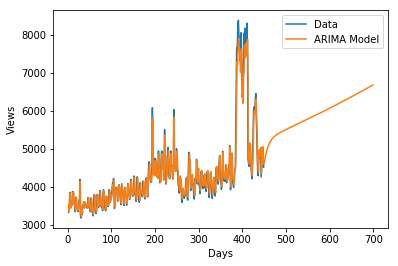

In [42]:
size = int(len(ts_log)-100)
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]

model = ARIMA(history, order=(1, 1, 1))
model_fit = model.fit(disp=0)
forecast = model_fit.predict(2,699,typ='levels')

x = [i for i in range(700)]

plt.plot(x[2:len(history)],np.exp(history[2:]) ,label='Data')
plt.plot(x[2:],np.exp(forecast),label='ARIMA Model')
plt.xlabel('Days')
plt.ylabel('Views')
plt.legend()
plt.show()

Similarly it can be done to predict for every language